<h1>Creating Digital Audio</h1>

With Python, we can create, record, and manipulate audio with just a few lines of code. After going through this notebook, you'll understand some of the basics of digital audio, and how we can interact with audio through code. Also, you'll see how powerful Python is, especially if we use some of the many available libraries.

A basic building block of audio is a sine tone. Actually, all sounds we hear can be modeled as a sum of different sine tones. So let's begin by creating a sine wave, listening to it, and looking at with different visualizations.

The main characteristic of a sine tone is it's _frequency_. The frequency sets the pitch of the sound - how high or low it sounds. The range of frequencies for human hearing is 20-20,000 Hz. What's a good frequency for our sine tone that's not too high or too low?

Think of an orchestra or symphony tuning together at the start of a performance. This is a fairly pleasing frequency.

In [112]:
from IPython.display import HTML, Audio, display, clear_output
%matplotlib inline
HTML('<iframe width="800" height="600" src="https://www.youtube.com/embed/KfSH1ezevjM?rel=0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

The tone they're tuning to is "A 440". It's the note A, at 440 _Hertz_. We can generate a digital version of this tone with a few lines of Python.

A tone is just a sine wave, following the formula

$$
wave = amplitude * \sin(2 * pi * frequency * time)
$$

The lines of code below save our parameters like the tone's frequency (440 Hz to match the orchestra sound), amplitude, and duration. We'll use these variables soon, to create the wave!

In [17]:
tone_frequency = 440
tone_amplitude = 0.5
tone_duration = 4

For digital audio, we need a sampling rate, or how often to create digital samples. Samples are the smallest unit of a digital audio wave, similar to how a pixel is the smallest unit in a digital image.

Let's set the sampling rate to 48,000 samples per second (also known as _Hertz_ or Hz), fast enough to capture all sounds in the range of human hearing. We could generate other very low or high pitches with this sampling rate.

This image shows an example of a digital audio signal. The red line is the original audio, and the blue dots are the digital representation. Sampling rate is how often to generate those blue dots.
![Digital Audio](img/4-bit-linear-PCM.svg)

We need a timeline for the samples, $t$. It will be a list of numbers representing the clock time for each sample. It starts at time zero, the next number is $T$, then $2*T$, $3*T$, and so on.

To help us make this list, we import numpy, which is a Python library useful for manipulating numbers, vectors, and matrices in Python.

numpy makes this timeline for us automatically, if we give it the start value, the end value, and the number of steps to take inbetween.

In [19]:
samplerate = 48000 # Sample period T = 1/samplerate
print ("One digital audio sample lasts just {:.10f} seconds!".format(1/samplerate))
import numpy as np
total_samples = tone_duration*samplerate+1
print ("We'll generate {} total samples".format(total_samples))
t = np.linspace(0, tone_duration, total_samples)
print("Our list of sample times: {}".format(t))

One digital audio sample lasts just 0.0000208333 seconds!
We'll generate 192001 total samples
Our list of sample times: [0.00000000e+00 2.08333333e-05 4.16666667e-05 ... 3.99995833e+00
 3.99997917e+00 4.00000000e+00]


Finally let's make the actual wave. Recall our formula...

$$
wave = amplitude * \sin(2 * pi * frequency * time)
$$

numpy helps us again by providing the sine function and the constant Pi.

In [42]:
wave = tone_amplitude * np.sin( 2 * np.pi * tone_frequency * t)

Our wave has been created! How can we check it out? Here's a function for listening to the audio, as well as visualizing it in time and frequency.

In [140]:
def view_audio(audio, Fs, min_sample=0, max_sample=-1):
    display(Audio(audio.squeeze(), rate=samplerate))
    
    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    rcParams.update({'font.size': 20})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
    plt.subplots_adjust(top=1.3)
    plot_audio = audio[min_sample:max_sample].squeeze()
    ax1.plot(plot_audio, '.', ms='2')
    ax1.set_title('Audio Samples')
    ax1.set_xlabel('Sample number'); ax1.set_ylabel('Sample amplitude')
    
    ## LABEL THE AXES
    
    ## switch to enable/disable each plot
    
    ax2.specgram(plot_audio, NFFT=1024, Fs=Fs, noverlap=256);
    ax2.set_yscale('log')
    ax2.set_ylim(10,20000)
    ax2.set_title('Spectrogram')
    ax2.set_xlabel('Time (sec)'); ax2.set_ylabel('Frequency (Hz)')
    

When you listen to the audio - does it sound similar to the orchestra clip? How is it different?

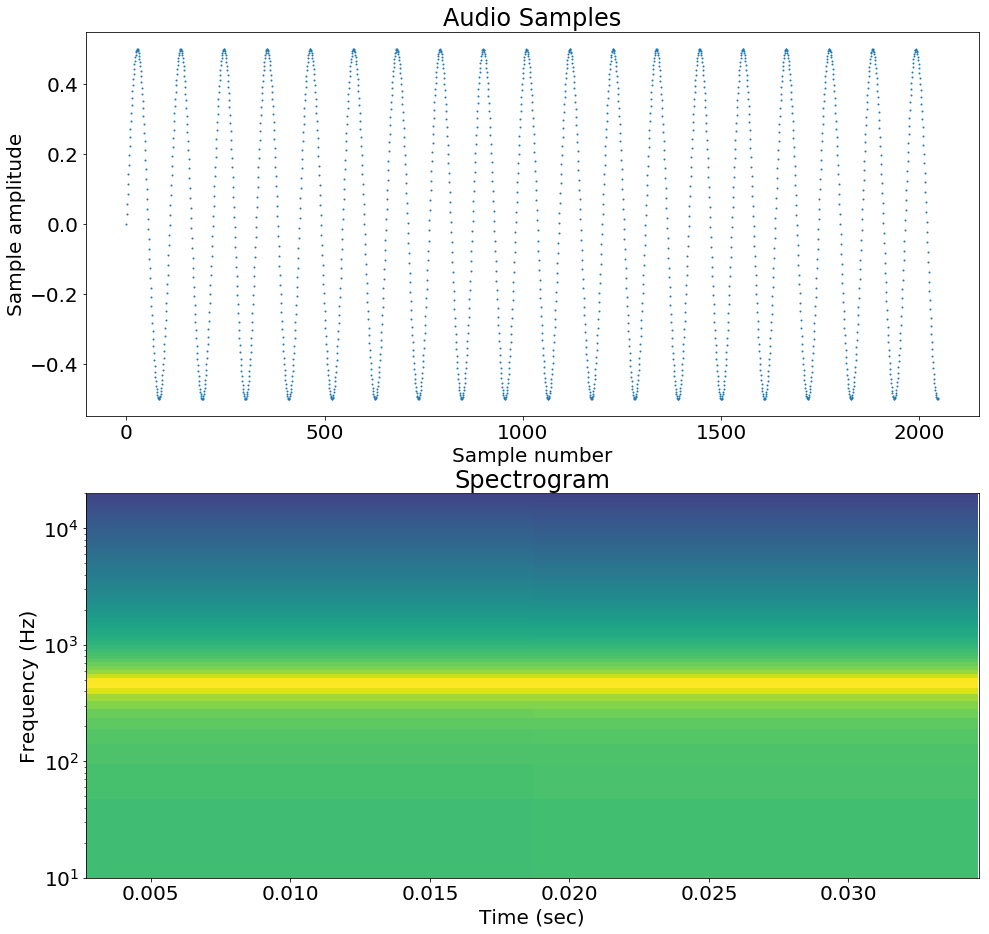

In [141]:
view_audio(wave, samplerate, min_sample=0, max_sample=2048)

Another interesting basic signal is a "chirp". We can sweep through some frequencies with a the wave, and the spectrogram shows us how the frequency changes over time.

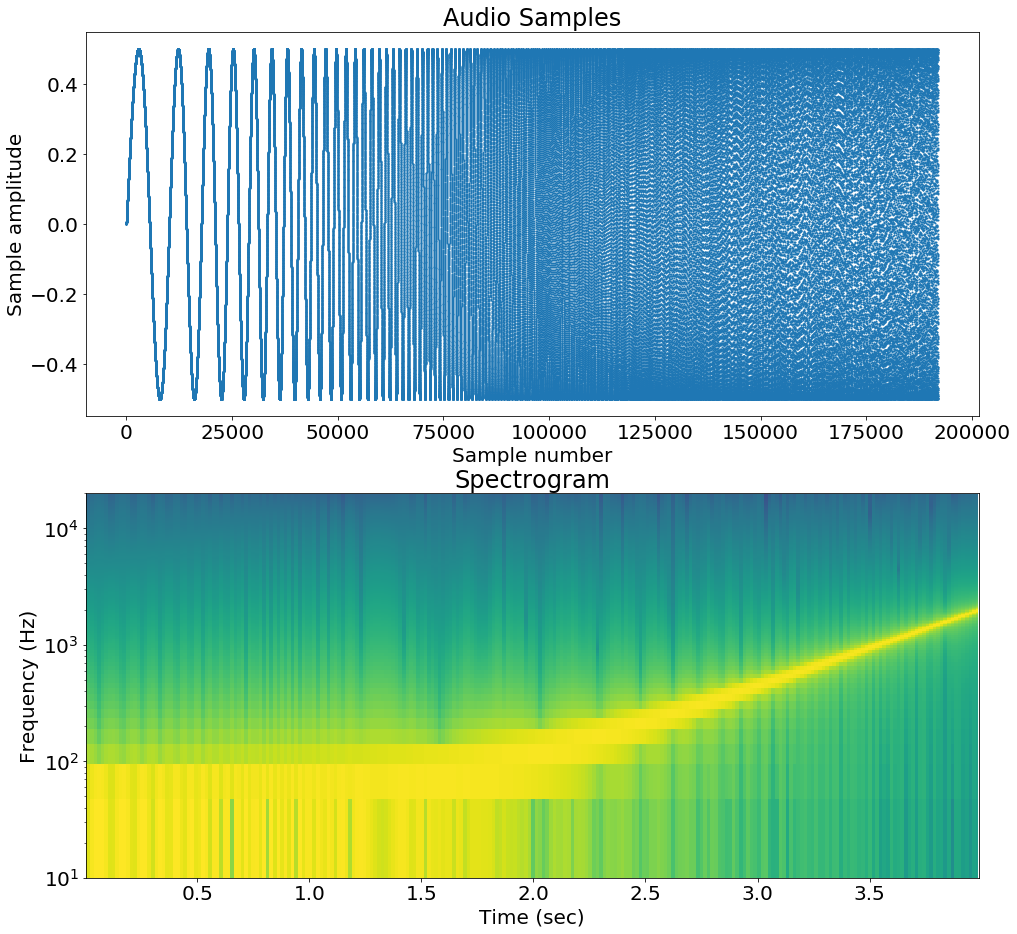

In [142]:
freq_sweep = np.logspace(np.log2(4),np.log2(2000),num=total_samples,base=2)
chirp_wave = tone_amplitude * np.sin( np.cumsum(2 * np.pi * freq_sweep/48000))
view_audio(chirp_wave, samplerate)

<h1>Recording Audio</h1>

These waves are easy to make in code, but it's pretty boring to listen to. Natural sounds you hear every day are more complex. Let's take a look at sounds recorded from a microphone. There's a Python library for recording and playing audio called sounddevice. First we'll check out the devices available to the computer for recording audio.

In [33]:
import sounddevice as sd
print(sd.query_devices())

> 0 Built-in Microphone, Core Audio (2 in, 0 out)
  1 Built-in Output, Core Audio (0 in, 2 out)
< 2 HDMI, Core Audio (0 in, 2 out)
  3 eqMac, Core Audio (2 in, 2 out)


Now we'll run the recording, giving the function info about duration, sample rate, and device

In [34]:
recording_duration = 5  # seconds
my_recording = sd.rec(recording_duration*samplerate, samplerate=samplerate, device=0, channels=1)
sd.wait()

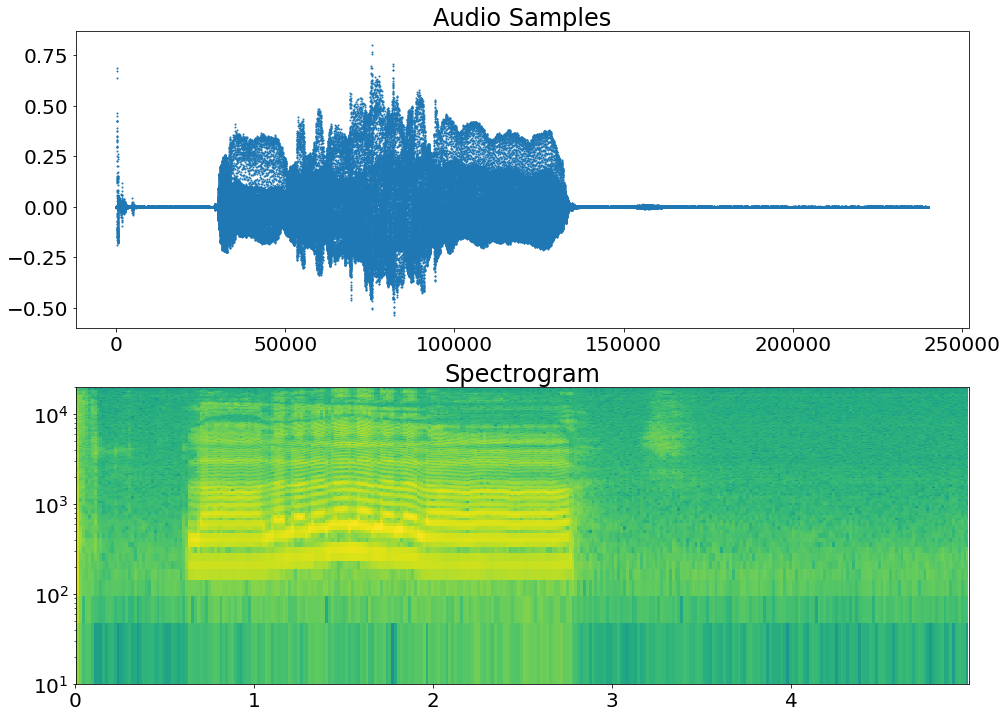

In [35]:
view_audio(my_recording, samplerate)

What do you notice about the plots of the samples and the spectrogram? Do they look like what you would expect?

<h1>Changing Audio</h1>

Now let's use code to change the way audio sounds.

One way to change audio is to filter out parts of the spectrum - we can attenuate some of the frequencies.

We'll use another Python library called scipy to calculate the filters for us. By changing the parameters of the filter, we can change how the filtered audio sounds.

Filter parameters: 0.004166666666666667 0.014166666666666668


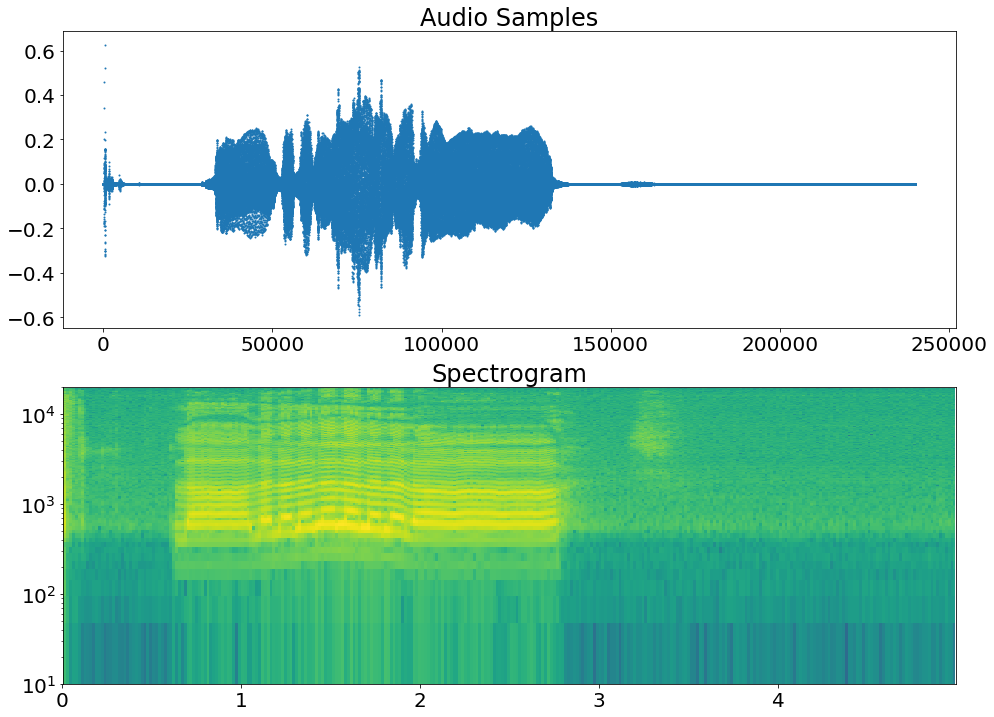

In [111]:
## BASS BOOST OF A MUSIC SAMPLE?
## CUTOFF IN THE MIDDLE OF CONTENT - different notes, different hands on a piano, different drum noises bass/hihat
from scipy.signal import iirdesign, lfilter
# iirdesign(wp, ws, gpass, gstop, analog=False, ftype='ellip', output='ba')
# examples:
# lowpass = iirdesign(0.05, 0.1, 1, 60)
# highpass = iirdesign(0.1, 0.05, 1, 60)
cutoff_frequency = 300
filt_f_lo = cutoff_frequency/samplerate*2
filt_f_hi = cutoff_frequency/samplerate*2 + 0.01
print("Filter parameters: {} {}".format(filt_low, filt_high))
low_filter = iirdesign(filt_f_lo, filt_f_hi, 1, 80)
high_filter = iirdesign(filt_f_hi, filt_f_lo, 1, 40)


filtered_audio = lfilter(*high_filter, my_recording.squeeze())
view_audio(filtered_audio, Fs=samplerate)

<h1>Reading Audio From a File</h1>

Python can also read sounds from a file. Then you can manipulate them in any way you like!

In [ ]:
from scipy.io.wavfile import read as wavread
file_Fs, file_wav = wavread('audio/scale.wav')
view_audio(file_wav, Fs=file_Fs)
print(file_Fs)

<h1>Try it out!</h1>

What other things can you imagine to manipulate sound? Or, use the filter functions with different parameters and listen to what happens!

In [8]:
# HACK: use saved file as recorded audio, in case recording doesn't work well
from scipy.io.wavfile import read as wavread
file_Fs, file_wav = wavread('audio/scale.wav')
my_recording = file_wav